In [1]:
import numpy as np
import random
from numpy import inf
from copy import deepcopy
import time
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plot

move_dict = {
  "A": 0, "a": 0,
  "B": 1, "b": 1,
  "C": 2, "c": 2,
  "D": 3, "d": 3,
  "E": 4, "e": 4,
}

class Teeko:
    def __init__(self, player1, player2):
        self.player1 = (player1, 1)  # Black Player
        self.player2 = (player2, 2)  # Red Player
        self.board = np.zeros((5,5))
        self.turn = 0
        self.current_player = self.player1
    
    def set_player(self, player):
        if player == 1:
            self.current_player = self.player1
        else: self.current_player = self.player2
    
    def switch_player(self):
        if self.current_player == self.player1:
            self.current_player = self.player2
        else: self.current_player = self.player1
        self.turn += 1
        
    def move_translator(self, selected):       #A5, B6 etc.
        yPos = selected[0]
        xPos = int(selected[1]) - 1
        return (move_dict[yPos], xPos)

    def make_a_move(self, selected, move = None):       # selected recibe posiciones reales tupla, move recibe la dirección  # move
        y, x = selected
        valid_move = True
        if self.board[y][x] != self.current_player[1] and move != None:
            valid_move = False
            return valid_move, selected
        if move is not None:
            for pos in move:
                if pos == "u" and y > 0:
                    y -= 1
                elif pos == "d" and y < 4:
                    y += 1
                elif pos == "r" and x < 4:
                    x += 1 
                elif pos == "l" and x > 0: 
                    x -= 1
                else: 
                    valid_move = False
        if valid_move and self.board[y][x] == 0:
            self.board[selected[0]][selected[1]] = 0
            limit = x >=0 and x < 5 and y >= 0 and y < 5
            if limit:
                selected = (y, x)
                self.board[selected[0]][selected[1]] = self.current_player[1]
            else: 
                print("Limites superados o posición ocupada")
                valid_move = False
        else: 
            print("Movimiento no válido, vuelva a intentarlo")   
            valid_move = False
            
        return valid_move, selected
        
    def check_horizontal(self, y):
        winner = False
        count = 0
        for row in self.board[y]:
            if row == self.current_player[1]:
                count += 1
            else: count = 0
            if count == 4:
                winner = True
        return winner

    def check_vertical(self, x):
        winner = False
        count = 0
        for col in range(5):
            if self.board[col][x] == self.current_player[1]:
                count += 1
            else: count = 0
            if count == 4:
                winner = True
        return winner
    
    def check_diagonal(self, matrix):
        winner = False
        count = 0
        for k in range(3):
            arr = np.diag(matrix, k - 1)
            for x in arr:
                if x == self.current_player[1]:
                    count += 1
                else: count = 0
                if count == 4:
                    winner = True
            if winner:
                break
        return winner
    
    def check_square(self, x, y):
        winner = False
        count = 0
        for i in range (2):
            if y + 1 < 5 and x + i < 5:
                if self.board[y][x + i] == self.current_player[1]:
                    count += 1
                if self.board[y + 1][x + i] == self.current_player[1]:
                    count += 1
        if count != 4:
            count = 0
            for i in range (2):
                if y - 1 >= 0 and x + i < 5:
                    if self.board[y][x + i] == self.current_player[1]:
                        count += 1
                    if self.board[y - 1][x + i] == self.current_player[1]:
                        count += 1
        if count != 4:
            count = 0
            for i in range (2):
                if y + 1 < 5 and x - i >= 0:
                    if self.board[y][x - i] == self.current_player[1]:
                        count += 1
                    if self.board[y + 1][x - i] == self.current_player[1]:
                        count += 1
        if count != 4:
            count = 0
            for i in range (2):
                if y - 1 >= 0 and x - i >= 0:
                    if self.board[y][x - i] == self.current_player[1]:
                        count += 1
                    if self.board[y - 1][x - i] == self.current_player[1]:
                        count += 1
        if count == 4:
            winner = True
        return winner

    def check_winner(self, last_position): #0,1 2,0
        y, x = last_position
        count = 0
        winner = False
        winner = self.check_horizontal(y)
        if not winner:
            winner = self.check_vertical(x)
        if not winner:
            winner = self.check_diagonal(self.board)
        if not winner:
            winner = self.check_diagonal(np.fliplr(self.board))
        if not winner:
            winner = self.check_square(x, y)
        return winner  
    
    def get_position(self):
        arr_pos = []
        phase1 = False
        if np.count_nonzero(self.board > 0) != 8:
            phase1 = True
        for y in range(5):
            for x in range(5):
                if phase1:
                    if self.board[y][x] == 0:
                        arr_pos.append((y,x))
                else:
                    if self.board[y][x] == self.current_player[1]:
                        arr_pos.append((y,x))
        return arr_pos
    
    def get_actions(self, selected):
        y, x = selected
        actions = ['u', 'd', 'l', 'r', 'ul', 'ur', 'dl', 'dr']
        valid_move = True
        valid_actions = []
        if np.count_nonzero(self.board > 0) != 8:
            return [None]
        for action in actions:
            valid_move = True
            y, x = selected
            for pos in action:
                if pos == "u" and y > 0:
                    y -= 1
                elif pos == "d" and y < 4:
                    y += 1
                elif pos == "r" and x < 4:
                    x += 1 
                elif pos == "l" and x > 0: 
                    x -= 1
                else: 
                    valid_move = False
            if valid_move and self.board[y][x] == 0:
                valid_actions.append(action)
        return valid_actions
    
    def heuristic(self, position):
        strength = 0
        mat = [[4,6,5,6,4],[6,10,10,10,6],[5,10,12,10,5],[6,10,10,10,6],[4,6,5,6,4]]
        
        for y in range(5):
            for x in range(5):
                if self.board[y][x] == self.player1[1]:
                    strength += mat[y][x]
                if self.board[y][x] == self.player2[1]:
                    strength -= mat[y][x]
        if self.current_player[0] == "MAX":
            strength -= self.turn * 2
        if self.current_player[0] == "MIN":
            strength += self.turn * 2
        if self.check_winner(position):
            if self.current_player[0] == "MAX":
                strength += 100
            if self.current_player[0] == "MIN":
                strength -= 100
        return strength

In [3]:
#Minimax with depth Algorithm (w/o Alpha Beta Pruning)

max_depth = 3

def min_max_with_depth_no_ABP(game):  #player MIN MAX, game es de la clase Teeko
    values = []
    i = 0
    mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
    actions = []
    moves = []
    pieces = []
    if game.current_player[0] == "MAX":
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min_value_with_depth_no_ABP(copyGame, selected, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmax(values)
    else:
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max_value_with_depth_no_ABP(copyGame, selected, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmin(values)
    return moves[i], pieces[i]

def min_value_with_depth_no_ABP(game, last_position, depth):    
    actions = []
    v = inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = min(v, max_value_with_depth_no_ABP(copyGame, selected, depth + 1))
    game.switch_player()
    return v

def max_value_with_depth_no_ABP(game, last_position, depth):
    actions = []
    v = -inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = max(v, min_value_with_depth_no_ABP(copyGame, selected, depth + 1)) 
    game.switch_player()
    return v

def cut_off(game, last_position, depth):
    return depth == max_depth or game.check_winner(last_position)

In [4]:
#Minimax with depth Algorithm (w/ Alpha Beta Pruning)


max_depth = 3

def min_max_with_depth(game):  #player MIN MAX, game es de la clase Teeko
    values = []
    i = 0
    mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
    actions = []
    moves = []
    pieces = []
    if game.current_player[0] == "MAX":
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min_value_with_depth(copyGame, selected,-inf, inf, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmax(values)
    else:
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max_value_with_depth(copyGame, selected,-inf, inf, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmin(values)
    return moves[i], pieces[i]

def min_value_with_depth(game, last_position, alpha, beta, depth):    
    actions = []
    v = inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = min(v, max_value_with_depth(copyGame, selected,alpha, beta, depth + 1))
                if v <= alpha:
                    return v
                beta = min(beta,v)
    game.switch_player()
    return v

def max_value_with_depth(game, last_position, alpha, beta, depth):
    actions = []
    v = -inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = max(v, min_value_with_depth(copyGame, selected,alpha, beta, depth + 1)) 
                if v >= beta:
                    return v
                alpha = max(alpha,v)
    game.switch_player()
    return v

def cut_off(game, last_position, depth):
    return depth == max_depth or game.check_winner(last_position)

In [5]:
#Minimax with depth Algorithm (w/ Alpha Beta Pruning and shuffle)

max_depth = 3

def min_max_with_depth_shuffle(game):  #player MIN MAX, game es de la clase Teeko
    values = []
    i = 0
    mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
    actions = []
    moves = []
    pieces = []
    random.shuffle(mark_position)
    if game.current_player[0] == "MAX":
        for mark in mark_position:
            actions = game.get_actions(mark)
            random.shuffle(actions)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min_value_with_depth_shuffle(copyGame, selected,-inf, inf, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmax(values)
    else:
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max_value_with_depth_shuffle(copyGame, selected,-inf, inf, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmin(values)
    return moves[i], pieces[i]

def min_value_with_depth_shuffle(game, last_position, alpha, beta, depth):    
    actions = []
    v = inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        random.shuffle(mark_position)
        for mark in mark_position:
            actions = game.get_actions(mark)
            random.shuffle(actions)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = min(v, max_value_with_depth_shuffle(copyGame, selected,alpha, beta, depth + 1))
                if v <= alpha:
                    return v
                beta = min(beta,v)
    game.switch_player()
    return v

def max_value_with_depth_shuffle(game, last_position, alpha, beta, depth):
    actions = []
    v = -inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        random.shuffle(mark_position)
        for mark in mark_position:
            actions = game.get_actions(mark)
            random.shuffle(actions)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = max(v, min_value_with_depth_shuffle(copyGame, selected,alpha, beta, depth + 1)) 
                if v >= beta:
                    return v
                alpha = max(alpha,v)
    game.switch_player()
    return v

def cut_off(game, last_position, depth):
    return depth == max_depth or game.check_winner(last_position)

# PRUEBAS
## Test 1 Min Max With Depth (ABP)

Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(None, (2, 2))
[3.9553701877593994] turn time
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(None, (1, 1))
[3.9553701877593994, 2.023733139038086] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
(None, (3, 1))
[3.9553701877593994, 2.023733139038086, 2.2516748905181885] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
(None, (3, 2))
[3.9553701877593994, 2.023733139038086, 2.2516748905181885, 1.2564518451690674] turn time
[[0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0.

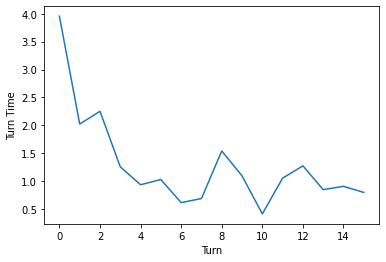

In [105]:
test_1_min_max = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_min_max.current_player)
test_1_min_max.make_a_move((4,2))   #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,2)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((1,0)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,2)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3), "u") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,1), "r") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((1,0), "r") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2), "u") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,3), "ul") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((0,2), "r") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((4,2), "ur") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,2), "dl") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((1,2), "r") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((4,1), "l") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3), "u") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,2), "u") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((1,3), "dl") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,1), "ul") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1), "dr") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((4,0), "ur") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,3), "dr") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,0), "d") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((1,1), "d") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2), "dr") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,2), "r") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,0), "d") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1), "u") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,3), "ul") #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,4), "d") #human move  --------------------------------HUMAN WINS-----------------------------------------------------
test_1_min_max.switch_player()
print(test_1_min_max.board)


plot.plot(range(16), turn_time)
plot.xlabel('Turn')
plot.ylabel('Turn Time')
plot.title('')
  
plot.show()

## Test 1 Min Max With Depth (w/o ABP)

In [106]:
test_1_no_abp = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_no_abp.current_player)
test_1_no_abp.make_a_move((4,2))   #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((2,2)) #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,1)) #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((1,1)) #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,3)) #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,1)) #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,0)) #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,2)) #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,3), "u") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((1,1), "r") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,0), "r") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")


test_1_no_abp.make_a_move((1,2), "u") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,3), "ul") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((0,2), "r") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((4,2), "ur") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,2), "dl") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,2), "r") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((4,1), "l") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,3), "u") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((2,2), "u") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,3), "dl") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,1), "ul") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,1), "dr") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((4,0), "ur") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,3), "dr") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((2,0), "d") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,1), "d") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((1,2), "dr") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,2), "r") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,0), "d") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,1), "u") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((2,3), "ul") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,4), "d") #human move  --------------------------------HUMAN WINS-----------------------------------------------------
test_1_no_abp.switch_player()
print(test_1_no_abp.board)


Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(None, (2, 2))
[16.323974132537842] turn time
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(None, (1, 1))
[16.323974132537842, 11.233874559402466] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
(None, (3, 1))
[16.323974132537842, 11.233874559402466, 7.497087001800537] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
(None, (3, 2))
[16.323974132537842, 11.233874559402466, 7.497087001800537, 4.724322080612183] turn time
[[0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0.

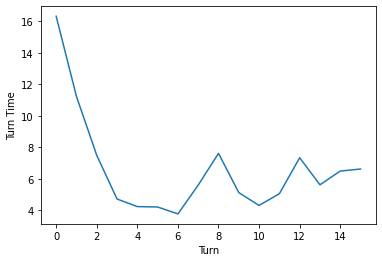

In [107]:

plot.plot(range(16), turn_time)
plot.xlabel('Turn')
plot.ylabel('Turn Time')
plot.title('')
  
plot.show()

## Test 1 Min Max With Depth (ABP and Shuffle)

In [6]:
test_1_no_abp = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_no_abp.current_player)
test_1_no_abp.make_a_move((4,2))   #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((2,2)) #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,1)) #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((1,1)) #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,3)) #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,1)) #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,0)) #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,2)) #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,3), "u") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((1,1), "r") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,0), "r") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")


test_1_no_abp.make_a_move((1,2), "u") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,3), "ul") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((0,2), "r") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((4,2), "ur") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,2), "dl") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,2), "r") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((4,1), "l") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,3), "u") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((2,2), "u") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,3), "dl") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,1), "ul") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,1), "dr") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((4,0), "ur") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,3), "dr") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((2,0), "d") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((1,1), "d") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((1,2), "dr") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,2), "r") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((3,0), "d") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((2,1), "u") #human move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_no_abp)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_no_abp.make_a_move((2,3), "ul") #computer move
test_1_no_abp.switch_player()
print(test_1_no_abp.board)

test_1_no_abp.make_a_move((3,4), "d") #human move  --------------------------------HUMAN WINS-----------------------------------------------------
test_1_no_abp.switch_player()
print(test_1_no_abp.board)


Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(None, (2, 2))
[2.0546953678131104] turn time
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(None, (1, 3))
[2.0546953678131104, 1.1008520126342773] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
(None, (3, 1))
[2.0546953678131104, 1.1008520126342773, 1.3689954280853271] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
(None, (3, 2))
[2.0546953678131104, 1.1008520126342773, 1.3689954280853271, 0.7988710403442383] turn time
[[0. 0. 0. 0. 0.]
 [1. 2. 0. 0.

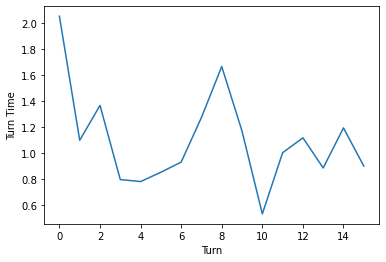

In [7]:
plot.plot(range(16), turn_time)
plot.xlabel('Turn')
plot.ylabel('Turn Time')
plot.title('')
  
plot.show()

## Test 2 Min Max With Depth (ABP)

In [108]:
test_1_min_max = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_min_max.current_player)
test_1_min_max.make_a_move((2,2))   #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((1,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((0,1)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((4,1)) #computer move --------------------------------COMPUTER WINS-----------------------------------------------------
test_1_min_max.switch_player()
print(test_1_min_max.board)

Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (1, 1))
[2.6007673740386963] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (3, 1))
[2.6007673740386963, 1.972583532333374] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (2, 1))
[2.6007673740386963, 1.972583532333374, 2.1539864540100098] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 2. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 2. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (4, 1))
[2.6007673740386963, 1.972583532333374, 2.1539864540100098, 1.312391996383667] turn time
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 1. 0.]

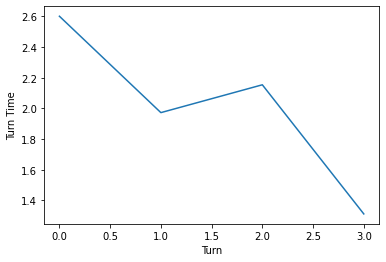

In [111]:

plot.plot(range(len(turn_time)), turn_time)
plot.xlabel('Turn')
plot.ylabel('Turn Time')
plot.title('')
  
plot.show()

## Test 2 Min Max With Depth (w/o ABP)

In [112]:
test_1_min_max = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_min_max.current_player)
test_1_min_max.make_a_move((2,2))   #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((1,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((0,1)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((4,1)) #computer move --------------------------------COMPUTER WINS-----------------------------------------------------
test_1_min_max.switch_player()
print(test_1_min_max.board)

Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (1, 1))
[16.410768032073975] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (3, 1))
[16.410768032073975, 11.319681882858276] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (2, 1))
[16.410768032073975, 11.319681882858276, 8.001715183258057] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 2. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 2. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (4, 1))
[16.410768032073975, 11.319681882858276, 8.001715183258057, 7.088113069534302] turn time
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 1. 0.

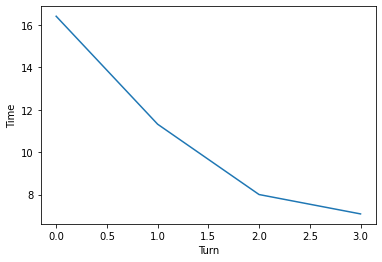

In [113]:

plot.plot(range(len(turn_time)), turn_time)
plot.xlabel('Turn')
plot.ylabel('Time')
plot.title('')
  
plot.show()

## Test 2 Min Max With Depth (ABP and Shuffle)

In [8]:
from sklearn.utils import shuffle


test_1_min_max = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_min_max.current_player)
test_1_min_max.make_a_move((2,2))   #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((1,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((0,1)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((4,1)) #computer move --------------------------------COMPUTER WINS-----------------------------------------------------
test_1_min_max.switch_player()
print(test_1_min_max.board)

Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (3, 2))
[1.4034202098846436] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (3, 1))
[1.4034202098846436, 1.7245335578918457] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (2, 1))
[1.4034202098846436, 1.7245335578918457, 1.7326633930206299] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 2. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 2. 1. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (4, 1))
[1.4034202098846436, 1.7245335578918457, 1.7326633930206299, 1.3749213218688965] turn time
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 1.

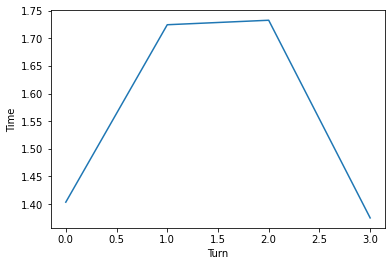

In [9]:
plot.plot(range(len(turn_time)), turn_time)
plot.xlabel('Turn')
plot.ylabel('Time')
plot.title('')
  
plot.show()

## Test 3 Min Max With Depth (ABP)

In [114]:
test_1_min_max = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_min_max.current_player)
test_1_min_max.make_a_move((2,2))   #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,3)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,2)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2)) #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1),"l") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2), "dl") #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,0),"d") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,3), "ul") #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,0),"dr") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2), "ul") #computer move --------------------------------COMPUTER WINS-----------------------------------------------------
test_1_min_max.switch_player()
print(test_1_min_max.board)


Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (1, 1))
[2.5328595638275146] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (2, 3))
[2.5328595638275146, 2.3426430225372314] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (3, 1))
[2.5328595638275146, 2.3426430225372314, 1.2153329849243164] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 2. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 2. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (1, 2))
[2.5328595638275146, 2.3426430225372314, 1.2153329849243164, 0.7285201549530029] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 2. 0.

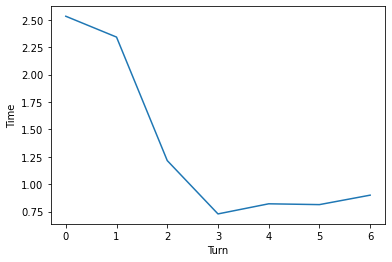

In [115]:

plot.plot(range(len(turn_time)), turn_time)
plot.xlabel('Turn')
plot.ylabel('Time')
plot.title('')
  
plot.show()

## Test 3 Min Max With Depth (w/o ABP)

In [116]:
test_1_min_max = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_min_max.current_player)
test_1_min_max.make_a_move((2,2))   #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,3)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,2)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2)) #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1),"l") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2), "dl") #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,0),"d") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,3), "ul") #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,0),"dr") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_no_ABP(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2), "ul") #computer move --------------------------------COMPUTER WINS-----------------------------------------------------
test_1_min_max.switch_player()
print(test_1_min_max.board)

Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (1, 1))
[16.394211530685425] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (2, 3))
[16.394211530685425, 11.651511669158936] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (3, 1))
[16.394211530685425, 11.651511669158936, 6.561973810195923] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 2. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 2. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (1, 2))
[16.394211530685425, 11.651511669158936, 6.561973810195923, 4.7649126052856445] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 2. 0. 0

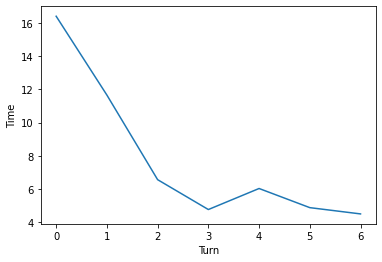

In [117]:
plot.plot(range(len(turn_time)), turn_time)
plot.xlabel('Turn')
plot.ylabel('Time')
plot.title('')
  
plot.show()

## Test 3 Min Max With Depth (ABP and Shuffle)

In [10]:
test_1_min_max = Teeko("MAX", "MIN")
turn_time = []

print("Primer Jugador: ", test_1_min_max.current_player)
test_1_min_max.make_a_move((2,2))   #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,3)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,2)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((3,1)) #computer move
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,3)) #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2)) #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,1),"l") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2), "dl") #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((2,0),"d") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((2,3), "ul") #computer move 
test_1_min_max.switch_player()
print(test_1_min_max.board)

test_1_min_max.make_a_move((3,0),"dr") #human move
test_1_min_max.switch_player()
print(test_1_min_max.board)
start = time.time()        
print(min_max_with_depth_shuffle(deepcopy(test_1_min_max)))
end = time.time()
turn_time.append(end - start)
print(turn_time, "turn time")

test_1_min_max.make_a_move((1,2), "ul") #computer move --------------------------------COMPUTER WINS-----------------------------------------------------
test_1_min_max.switch_player()
print(test_1_min_max.board)


Primer Jugador:  ('MAX', 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (1, 3))
[1.4366178512573242] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (2, 3))
[1.4366178512573242, 1.6594328880310059] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]
(None, (3, 1))
[1.4366178512573242, 1.6594328880310059, 0.8918640613555908] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 2. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0.]
 [0. 2. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]
(None, (1, 2))
[1.4366178512573242, 1.6594328880310059, 0.8918640613555908, 0.876107931137085] turn time
[[0. 0. 0. 0. 0.]
 [0. 2. 2. 0. 

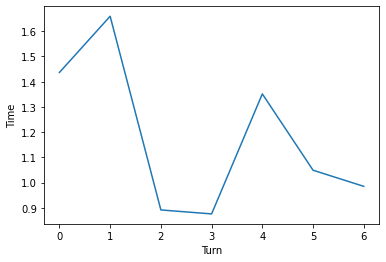

In [11]:
plot.plot(range(len(turn_time)), turn_time)
plot.xlabel('Turn')
plot.ylabel('Time')
plot.title('')
  
plot.show()